In [1]:
import pandas as pd
import numpy as np
import subprocess
import random
from scipy import stats
import glob
import math
import csv
import sys
import os

import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"
%matplotlib inline

In [2]:
# declarations
base_dir_data = "/ccb/salz8-1/avaraby/tx_noise/data/"
base_dir_out = "/ccb/salz8-1/avaraby/tx_noise/full_analysis_t3_s10_26022020/GTEx_aggs/"
out_dir = "/ccb/salz8-1/avaraby/tx_noise/full_analysis_t3_s10_26022020/sim_samples/"

num_tissues = 3
num_samples = 10

gff3cols=["seqid","source","type","start","end","score","strand","phase","attributes"]

In [3]:
real_gtf = pd.read_csv(base_dir_data+"real.gtf",sep="\t",names=gff3cols)
real_gtf["tid_real"] = real_gtf["attributes"].str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
splice_gtf = pd.read_csv(base_dir_data+"splicing.gtf",sep="\t",names=gff3cols)
splice_gtf["tid_splicing"] = splice_gtf["attributes"].str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
int_gtf = pd.read_csv(base_dir_data+"intronic.gtf",sep="\t",names=gff3cols)
int_gtf["tid_intronic"] = int_gtf["attributes"].str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
pol_gtf = pd.read_csv(base_dir_data+"RNApol.gtf",sep="\t",names=gff3cols)
pol_gtf["tid_intergenic"] = pol_gtf["attributes"].str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]

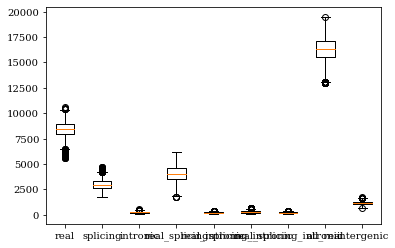

In [4]:
# based on the number of loci per sample
s_loc = pd.read_csv(base_dir_out+"res.num_locs_sample")

for label in s_loc.columns:
    # now we shall remove any outliers from the data
    q25,q50,q75 = s_loc[label].quantile([0.25,0.5,0.75])
    iqr = q75-q25
    thw = q75+1.5*iqr
    tlw = q25-1.5*iqr
    ahw = s_loc[s_loc[label]<=thw][label].max()
    alw = s_loc[s_loc[label]>=tlw][label].min()
    s_loc = s_loc[(s_loc[label]<=ahw)&(s_loc[label]>=alw)].reset_index(drop=True)

fig,ax = plt.subplots()
ax.boxplot(s_loc.T,labels=s_loc.T.index.tolist())
plt.show()

In [8]:
for tissue_num in range(num_tissues):
    print("\n=================\nTissue #"+str(tissue_num)+"\n=================\n")
    realDF = pd.read_csv(out_dir+"stage2_tid_lid_exp.real_t"+str(tissue_num))
    spliceDF = pd.read_csv(out_dir+"stage2_tid_lid_exp.splice_t"+str(tissue_num))
    intDF = pd.read_csv(out_dir+"stage2_tid_lid_exp.int_t"+str(tissue_num))
    polDF = pd.read_csv(out_dir+"stage2_tid_lid_exp.pol_t"+str(tissue_num))
    
    print("starting number of real loci: "+str(len(set(realDF["lid"]))))
    print("starting number of splicing loci: "+str(len(set(spliceDF["lid"]))))
    print("starting number of intronic loci: "+str(len(set(intDF["lid"]))))
    print("starting number of intergenic loci: "+str(len(set(polDF["lid"]))))
    
    for sample_num in range(num_samples):
        print("++++++\n>Sample #"+str(sample_num)+"\n++++++\n")
        # ==================================
        # get numbers
        # ==================================
        realn,splicen,intn,real_splicen,real_intn,splice_intn,real_splice_intn,all_realn,poln = s_loc.sample()[["real",\
                                                                                                                "splicing",\
                                                                                                                "intronic",\
                                                                                                                "real_splicing",\
                                                                                                                "real_intronic",\
                                                                                                                "splicing_intronic",\
                                                                                                                "real_splicing_intronic",\
                                                                                                                "all_real",\
                                                                                                                "intergenic"]].iloc[0].tolist()
        
        # ==================================
        # Now to generate sample from tissue
        # for intergenic set
        # ==================================
        
        # now let's split this into samples the old way
        # now let's split this into samples the old way
        realDF_g = realDF.groupby("lid").agg({"tid_real":{"tids_real":lambda x:list(x),
                                                                "count_real":"count"},
                                              "real_tpms":"first"}).reset_index()
        realDF_g.columns = ["lid","tids_real","count_real","real_tpms"]
        realDF_g["real_tpms"] = realDF_g["real_tpms"].str.split(";")

        # now let's split this into samples the old way
        spliceDF_g = spliceDF.groupby("lid").agg({"tid_splicing":{"tids_splicing":lambda x:list(x),
                                                                "count_splicing":"count"},
                                              "splicing_tpms":"first"}).reset_index()
        spliceDF_g.columns = ["lid","tids_splicing","count_splicing","splicing_tpms"]
        spliceDF_g["splicing_tpms"] = spliceDF_g["splicing_tpms"].str.split(";")

        # now let's split this into samples the old way
        intDF_g = intDF.groupby("lid").agg({"tid_intronic":{"tids_intronic":lambda x:list(x),
                                                                "count_intronic":"count"},
                                              "intronic_tpms":"first"}).reset_index()
        intDF_g.columns = ["lid","tids_intronic","count_intronic","intronic_tpms"]
        intDF_g["intronic_tpms"] = intDF_g["intronic_tpms"].str.split(";")

        # now let's split this into samples the old way
        polDF_g = polDF.groupby("lid").agg({"tid_intergenic":{"tids_intergenic":lambda x:list(x),
                                                                "count_intergenic":"count"},
                                              "intergenic_tpms":"first"}).reset_index()
        polDF_g.columns = ["lid","tids_intergenic","count_intergenic","intergenic_tpms"]
        polDF_g["intergenic_tpms"] = polDF_g["intergenic_tpms"].str.split(";")

        all_g_lid = realDF_g.merge(spliceDF_g,how="outer",on="lid")
        all_g_lid = all_g_lid.merge(intDF_g,how="outer",on="lid")
        all_g_lid = all_g_lid.merge(polDF_g,how="outer",on="lid")
        all_g_lid["count_real"] = all_g_lid["count_real"].fillna(0)
        all_g_lid["count_splicing"] = all_g_lid["count_splicing"].fillna(0)
        all_g_lid["count_intronic"] = all_g_lid["count_intronic"].fillna(0)
        all_g_lid["count_intergenic"] = all_g_lid["count_intergenic"].fillna(0)

        all_g_lid["count_real"]=all_g_lid["count_real"].astype(int)
        all_g_lid["count_splicing"]=all_g_lid["count_splicing"].astype(int)
        all_g_lid["count_intronic"]=all_g_lid["count_intronic"].astype(int)
        all_g_lid["count_intergenic"]=all_g_lid["count_intergenic"].astype(int)

        all_g_lid.fillna("",inplace=True)

        # need a function to get the samples from this now
        lids_intergenic=[]
        tids_intergenic=[]
        tpms_intergenic=[]

        lids_real=[]
        tids_real=[]
        tpms_real=[]

        lids_splicing=[]
        tids_splicing=[]
        tpms_splicing=[]

        lids_intronic=[]
        tids_intronic=[]
        tpms_intronic=[]

        def get_samples(row):
            global lids_intergenic
            global tids_intergenic
            global tpms_intergenic
            if(row["count_intergenic"]>0):
                all_intergenic_tids = np.array(row["tids_intergenic"])
                all_intergenic_tpms = row["intergenic_tpms"]
                # randomly choose a sample
                rand_sample_idx = random.randint(0,len(all_intergenic_tpms)-1)
                tmp_tpms = all_intergenic_tpms[rand_sample_idx].split("-")
                tid_ids = []
                res_tpms = []
                for i in range(len(tmp_tpms)):
                    if not tmp_tpms[i]=="0":
                        tid_ids.append(i)
                        res_tpms.append(float(tmp_tpms[i]))
                res_tids = all_intergenic_tids[tid_ids]
                lids_intergenic.extend([row["lid"] for i in range(len(res_tids))])
                tids_intergenic.extend(res_tids)
                tpms_intergenic.extend(res_tpms)
            else:
                all_real_tpms = row["real_tpms"]
                all_splicing_tpms = row["splicing_tpms"]
                all_intronic_tpms = row["intronic_tpms"]

                all_real_tids = np.array(row["tids_real"])
                all_splicing_tids = np.array(row["tids_splicing"])
                all_intronic_tids = np.array(row["tids_intronic"])

                num_observations = max(len(all_real_tpms),len(all_splicing_tpms),len(all_intronic_tpms))
                rand_sample_idx = random.randint(0,num_observations-1)

                if row["count_real"]>0:
                    assert len(all_real_tpms)==num_observations
                    tmp_tpms = all_real_tpms[rand_sample_idx].split("-")
                    tid_ids = []
                    res_tpms = []
                    for i in range(len(tmp_tpms)):
                        if not tmp_tpms[i]=="0":
                            tid_ids.append(i)
                            res_tpms.append(float(tmp_tpms[i]))
                    res_tids = all_real_tids[tid_ids]
                    lids_real.extend([row["lid"] for i in range(len(res_tids))])
                    tids_real.extend(res_tids)
                    tpms_real.extend(res_tpms)
                if row["count_splicing"]>0:
                    assert len(all_splicing_tpms)==num_observations
                    tmp_tpms = all_splicing_tpms[rand_sample_idx].split("-")
                    tid_ids = []
                    res_tpms = []
                    for i in range(len(tmp_tpms)):
                        if not tmp_tpms[i]=="0":
                            tid_ids.append(i)
                            res_tpms.append(float(tmp_tpms[i]))
                    res_tids = all_splicing_tids[tid_ids]
                    lids_splicing.extend([row["lid"] for i in range(len(res_tids))])
                    tids_splicing.extend(res_tids)
                    tpms_splicing.extend(res_tpms)
                if row["count_intronic"]>0:
                    assert len(all_intronic_tpms)==num_observations
                    tmp_tpms = all_intronic_tpms[rand_sample_idx].split("-")
                    tid_ids = []
                    res_tpms = []
                    for i in range(len(tmp_tpms)):
                        if not tmp_tpms[i]=="0":
                            tid_ids.append(i)
                            res_tpms.append(float(tmp_tpms[i]))
                    res_tids = all_intronic_tids[tid_ids]
                    lids_intronic.extend([row["lid"] for i in range(len(res_tids))])
                    tids_intronic.extend(res_tids)
                    tpms_intronic.extend(res_tpms)

        all_g_lid.apply(lambda row: get_samples(row),axis=1)
        
        print("number of real transcripts: "+str(len(set(tids_real))))
        print("number of splicing transcripts: "+str(len(set(tids_splicing))))
        print("number of intronic transcripts: "+str(len(set(tids_intronic))))
        print("number of intergenic transcripts: "+str(len(set(tids_intergenic))))
        print("number of real genes: "+str(len(set(lids_real))))
        print("number of solicing genes: "+str(len(set(lids_splicing))))
        print("number of intronic genes: "+str(len(set(lids_intronic))))
        print("number of intergenic genes: "+str(len(set(lids_intergenic))))

        print("targeting "+str(realn)+" real only loci")
        print("targeting "+str(splicen)+" splicing only loci")
        print("targeting "+str(intn)+" intronic only loci")
        print("targeting "+str(real_splicen)+" real and splicing loci")
        print("targeting "+str(real_intn)+" real and intronic loci")
        print("targeting "+str(splice_intn)+" splicing and intronic loci")
        print("targeting "+str(real_splice_intn)+" real and splicing and intronic loci")
        print("targeting "+str(poln)+" intergenic loci")

        real_sample_locs = set(lids_real)
        splicing_sample_locs = set(lids_splicing)
        intronic_sample_locs = set(lids_intronic)
        intergenic_sample_locs = list(set(lids_intergenic))

        real_only_sample_locs = list(real_sample_locs-(splicing_sample_locs.union(intronic_sample_locs)))
        splicing_only_sample_locs = list(splicing_sample_locs-(real_sample_locs.union(intronic_sample_locs)))
        intronic_only_sample_locs = list(intronic_sample_locs-(real_sample_locs.union(splicing_sample_locs)))

        real_splicing_sample_locs = list(real_sample_locs.intersection(splicing_sample_locs)-intronic_sample_locs)
        real_intronic_sample_locs = list(real_sample_locs.intersection(intronic_sample_locs)-splicing_sample_locs)
        splicing_intronic_sample_locs = list(splicing_sample_locs.intersection(intronic_sample_locs)-real_sample_locs)

        real_splicing_intronic_sample_locs = list(real_sample_locs.intersection(splicing_sample_locs.intersection(intronic_sample_locs)))

        print("available real only loci: "+str(len(real_only_sample_locs)))
        print("available splicing only loci: "+str(len(splicing_only_sample_locs)))
        print("available intronic only loci: "+str(len(intronic_only_sample_locs)))
        print("available real and splicing loci: "+str(len(real_splicing_sample_locs)))
        print("available real and intronic loci: "+str(len(real_intronic_sample_locs)))
        print("available splicing and intronic loci: "+str(len(splicing_intronic_sample_locs)))
        print("available real and splicing and intronic loci: "+str(len(real_splicing_intronic_sample_locs)))
        print("available intergenic only loci: "+str(len(intergenic_sample_locs)))

        random.shuffle(real_only_sample_locs)
        min_realn = min(len(real_only_sample_locs),realn)
        real_only_sample_locs = real_only_sample_locs[:min_realn]
        random.shuffle(splicing_only_sample_locs)
        min_splicen = min(len(splicing_only_sample_locs),splicen)
        splicing_only_sample_locs = splicing_only_sample_locs[:min_splicen]
        random.shuffle(intronic_only_sample_locs)
        min_intn = min(len(intronic_only_sample_locs),intn)
        intronic_only_sample_locs = intronic_only_sample_locs[:min_intn]
        random.shuffle(intergenic_sample_locs)
        min_poln = min(len(intergenic_sample_locs),poln)
        intergenic_sample_locs = intergenic_sample_locs[:min_poln]

        random.shuffle(real_splicing_sample_locs)
        min_real_splicen = min(len(real_splicing_sample_locs),real_splicen)
        real_splicing_sample_locs = real_splicing_sample_locs[:min_real_splicen]
        random.shuffle(real_intronic_sample_locs)
        min_real_intn = min(len(real_intronic_sample_locs),real_intn)
        real_intronic_sample_locs = real_intronic_sample_locs[:min_real_intn]
        random.shuffle(splicing_intronic_sample_locs)
        min_splice_intn = min(len(splicing_intronic_sample_locs),splice_intn)
        splicing_intronic_sample_locs = splicing_intronic_sample_locs[:min_splice_intn]

        random.shuffle(real_splicing_intronic_sample_locs)
        min_real_splice_intn = min(len(real_splicing_intronic_sample_locs),real_splice_intn)
        real_splicing_intronic_sample_locs = real_splicing_intronic_sample_locs[:min_real_splice_intn]

        print("selecting real only loci: "+str(len(real_only_sample_locs)))
        print("selecting splicing only loci: "+str(len(splicing_only_sample_locs)))
        print("selecting intronic only loci: "+str(len(intronic_only_sample_locs)))
        print("selecting real and splicing loci: "+str(len(real_splicing_sample_locs)))
        print("selecting real and intronic loci: "+str(len(real_intronic_sample_locs)))
        print("selecting splicing and intronic loci: "+str(len(splicing_intronic_sample_locs)))
        print("selecting real and splicing and intronic loci: "+str(len(real_splicing_intronic_sample_locs)))
        print("selecting intergenic loci: "+str(len(intergenic_sample_locs)))
        
        real_sub = pd.concat([pd.DataFrame(lids_real,columns=["lid"]),pd.DataFrame(tids_real,columns=["tid"]),pd.DataFrame(tpms_real,columns=["tpm"])],axis=1)
        splicing_sub = pd.concat([pd.DataFrame(lids_splicing,columns=["lid"]),pd.DataFrame(tids_splicing,columns=["tid"]),pd.DataFrame(tpms_splicing,columns=["tpm"])],axis=1)
        intronic_sub = pd.concat([pd.DataFrame(lids_intronic,columns=["lid"]),pd.DataFrame(tids_intronic,columns=["tid"]),pd.DataFrame(tpms_intronic,columns=["tpm"])],axis=1)
        intergenic_sub = pd.concat([pd.DataFrame(lids_intergenic,columns=["lid"]),pd.DataFrame(tids_intergenic,columns=["tid"]),pd.DataFrame(tpms_intergenic,columns=["tpm"])],axis=1)
        
        real_only_sample_df = real_sub[real_sub["lid"].isin(real_only_sample_locs)].reset_index(drop=True)
        splicing_only_sample_df = splicing_sub[splicing_sub["lid"].isin(splicing_only_sample_locs)].reset_index(drop=True)
        intronic_only_sample_df = intronic_sub[intronic_sub["lid"].isin(intronic_only_sample_locs)].reset_index(drop=True)
        intergenic_sub2 = intergenic_sub[intergenic_sub["lid"].isin(intergenic_sample_locs)].reset_index(drop=True)

        real_splicing_only_sample_df = real_sub[real_sub["lid"].isin(real_splicing_sample_locs)].reset_index(drop=True)
        splicing_real_only_sample_df = splicing_sub[splicing_sub["lid"].isin(real_splicing_sample_locs)].reset_index(drop=True)

        real_intronic_only_sample_df = real_sub[real_sub["lid"].isin(real_intronic_sample_locs)].reset_index(drop=True)
        intronic_real_only_sample_df = intronic_sub[intronic_sub["lid"].isin(real_intronic_sample_locs)].reset_index(drop=True)

        splicing_intronic_only_sample_df = splicing_sub[splicing_sub["lid"].isin(splicing_intronic_sample_locs)].reset_index(drop=True)
        intronic_splicing_only_sample_df = intronic_sub[intronic_sub["lid"].isin(splicing_intronic_sample_locs)].reset_index(drop=True)

        real_splicing_intronic_only_sample_df = real_sub[real_sub["lid"].isin(real_splicing_intronic_sample_locs)].reset_index(drop=True)
        splicing_real_intronic_only_sample_df = splicing_sub[splicing_sub["lid"].isin(real_splicing_intronic_sample_locs)].reset_index(drop=True)
        intronic_real_splicing_only_sample_df = intronic_sub[intronic_sub["lid"].isin(real_splicing_intronic_sample_locs)].reset_index(drop=True)

        real_sub2 = pd.concat([real_only_sample_df,\
                               real_splicing_only_sample_df,\
                               real_intronic_only_sample_df,\
                               real_splicing_intronic_only_sample_df],axis=0).reset_index(drop=True)
        splicing_sub2 = pd.concat([splicing_only_sample_df,\
                                   splicing_real_only_sample_df,\
                                   splicing_intronic_only_sample_df,\
                                   splicing_real_intronic_only_sample_df],axis=0).reset_index(drop=True)
        intronic_sub2 = pd.concat([intronic_only_sample_df,\
                                   intronic_real_only_sample_df,\
                                   intronic_splicing_only_sample_df,\
                                   intronic_real_splicing_only_sample_df],axis=0).reset_index(drop=True)

        print("final number of real transcripts: "+str(len(set(real_sub2["tid"]))))
        print("final number of splicing transcripts: "+str(len(set(splicing_sub2["tid"]))))
        print("final number of intronic transcripts: "+str(len(set(intronic_sub2["tid"]))))
        print("final number of intergenic transcripts: "+str(len(set(intergenic_sub2["tid"]))))
        print("final number of real loci: "+str(len(set(real_sub2["lid"]))))
        print("final number of splicing loci: "+str(len(set(splicing_sub2["lid"]))))
        print("final number of intronic loci: "+str(len(set(intronic_sub2["lid"]))))
        print("final number of intergenic loci: "+str(len(set(intergenic_sub2["lid"]))))

        ttx_real = list(real_sub2["tid"])
        tpm_real = list(real_sub2["tpm"])

        ttx_splice = list(splicing_sub2["tid"])
        tpm_splice = list(splicing_sub2["tpm"])

        ttx_int = list(intronic_sub2["tid"])
        tpm_int = list(intronic_sub2["tpm"])

        ttx_intergenic = list(intergenic_sub2["tid"])
        tpm_intergenic = list(intergenic_sub2["tpm"])

        # now we can save the results
        res_real = pd.concat([pd.DataFrame(ttx_real,columns=["tid_real"]),pd.DataFrame(tpm_real,columns=["tpm"])],axis=1)
        realDF_f = realDF[["lid","tid_real"]].merge(res_real,on="tid_real",how="inner")
        realDF_f = real_gtf.merge(realDF_f[["tid_real","tpm"]],on="tid_real",how="inner")
        realDF_f["attributes"] = realDF_f["attributes"].str.rstrip(";")+\
                                    ";sim_tpm="+realDF_f["tpm"].astype(str)
        realDF_f[gff3cols].to_csv(out_dir+"real.t"+str(tissue_num)+"_s"+str(sample_num)+".gtf",sep="\t",index=False,header=False,quoting=csv.QUOTE_NONE)
        realDF_f[realDF_f["type"]=="transcript"][["tpm"]].to_csv(out_dir+"real.t"+str(tissue_num)+"_s"+str(sample_num)+".exp",index=False,header=False)

        res_splicing = pd.concat([pd.DataFrame(ttx_splice,columns=["tid_splicing"]),pd.DataFrame(tpm_splice,columns=["tpm"])],axis=1)
        splicingDF_f = spliceDF[["lid","tid_splicing"]].merge(res_splicing,on="tid_splicing",how="inner")
        splicingDF_f = splice_gtf.merge(splicingDF_f[["tid_splicing","tpm"]],on="tid_splicing",how="inner")
        splicingDF_f["attributes"] = splicingDF_f["attributes"].str.rstrip(";")+\
            ";sim_tpm="+splicingDF_f["tpm"].astype(str)
        splicingDF_f[gff3cols].to_csv(out_dir+"splicing.t"+str(tissue_num)+"_s"+str(sample_num)+".gtf",sep="\t",index=False,header=False,quoting=csv.QUOTE_NONE)
        splicingDF_f[splicingDF_f["type"]=="transcript"][["tpm"]].to_csv(out_dir+"splicing.t"+str(tissue_num)+"_s"+str(sample_num)+".exp",index=False,header=False)
        splicingDF_f.head()

        res_intronic = pd.concat([pd.DataFrame(ttx_int,columns=["tid_intronic"]),pd.DataFrame(tpm_int,columns=["tpm"])],axis=1)
        intronicDF_f = intDF[["lid","tid_intronic"]].merge(res_intronic,on="tid_intronic",how="inner")
        intronicDF_f = int_gtf.merge(intronicDF_f[["tid_intronic","tpm"]],on="tid_intronic",how="inner")
        intronicDF_f["attributes"] = intronicDF_f["attributes"].str.rstrip(";")+\
            ";sim_tpm="+intronicDF_f["tpm"].astype(str)
        intronicDF_f[gff3cols].to_csv(out_dir+"intronic.t"+str(tissue_num)+"_s"+str(sample_num)+".gtf",sep="\t",index=False,header=False,quoting=csv.QUOTE_NONE)
        intronicDF_f[intronicDF_f["type"]=="transcript"][["tpm"]].to_csv(out_dir+"intronic.t"+str(tissue_num)+"_s"+str(sample_num)+".exp",index=False,header=False)

        res_intergenic = pd.concat([pd.DataFrame(ttx_intergenic,columns=["tid_intergenic"]),pd.DataFrame(tpm_intergenic,columns=["tpm"])],axis=1)
        intergenicDF_f = polDF[["lid","tid_intergenic"]].merge(res_intergenic,on="tid_intergenic",how="inner")
        intergenicDF_f = pol_gtf.merge(intergenicDF_f[["tid_intergenic","tpm"]],on="tid_intergenic",how="inner")
        intergenicDF_f["attributes"] = intergenicDF_f["attributes"].str.rstrip(";")+\
                                    ";sim_tpm="+intergenicDF_f["tpm"].astype(str)
        intergenicDF_f[gff3cols].to_csv(out_dir+"intergenic.t"+str(tissue_num)+"_s"+str(sample_num)+".gtf",sep="\t",index=False,header=False,quoting=csv.QUOTE_NONE)
        intergenicDF_f[intergenicDF_f["type"]=="transcript"][["tpm"]].to_csv(out_dir+"intergenic.t"+str(tissue_num)+"_s"+str(sample_num)+".exp",index=False,header=False)



Tissue #0

starting number of real loci: 31218
starting number of splicing loci: 25878
starting number of intronic loci: 14519
starting number of intergenic loci: 29016
++++++
>Sample #0
++++++

number of real transcripts: 39655
number of splicing transcripts: 20485
number of intronic transcripts: 4243
number of intergenic transcripts: 29431
number of real genes: 20867
number of solicing genes: 13335
number of intronic genes: 2961
number of intergenic genes: 29013
targeting 8747 real only loci
targeting 2821 splicing only loci
targeting 181 intronic only loci
targeting 4152 real and splicing loci
targeting 193 real and intronic loci
targeting 206 splicing and intronic loci
targeting 155 real and splicing and intronic loci
targeting 1136 intergenic loci
available real only loci: 15968
available splicing only loci: 8049
available intronic only loci: 1523
available real and splicing loci: 4233
available real and intronic loci: 385
available splicing and intronic loci: 772
available real 

final number of real transcripts: 27988
final number of splicing transcripts: 13239
final number of intronic transcripts: 1593
final number of intergenic transcripts: 1277
final number of real loci: 13475
final number of splicing loci: 8291
final number of intronic loci: 1082
final number of intergenic loci: 1254
++++++
>Sample #6
++++++

number of real transcripts: 39281
number of splicing transcripts: 20480
number of intronic transcripts: 4264
number of intergenic transcripts: 29396
number of real genes: 20741
number of solicing genes: 13361
number of intronic genes: 3015
number of intergenic genes: 29013
targeting 7806 real only loci
targeting 2925 splicing only loci
targeting 268 intronic only loci
targeting 4642 real and splicing loci
targeting 275 real and intronic loci
targeting 348 splicing and intronic loci
targeting 229 real and splicing and intronic loci
targeting 1091 intergenic loci
available real only loci: 15937
available splicing only loci: 8159
available intronic only 

final number of real transcripts: 26521
final number of splicing transcripts: 10975
final number of intronic transcripts: 882
final number of intergenic transcripts: 1073
final number of real loci: 12889
final number of splicing loci: 6665
final number of intronic loci: 591
final number of intergenic loci: 1063
++++++
>Sample #2
++++++

number of real transcripts: 37758
number of splicing transcripts: 19722
number of intronic transcripts: 4042
number of intergenic transcripts: 29368
number of real genes: 19700
number of solicing genes: 12675
number of intronic genes: 2857
number of intergenic genes: 29016
targeting 8685 real only loci
targeting 2688 splicing only loci
targeting 271 intronic only loci
targeting 4339 real and splicing loci
targeting 218 real and intronic loci
targeting 204 splicing and intronic loci
targeting 152 real and splicing and intronic loci
targeting 1204 intergenic loci
available real only loci: 15054
available splicing only loci: 7657
available intronic only lo

final number of real transcripts: 25855
final number of splicing transcripts: 10918
final number of intronic transcripts: 1010
final number of intergenic transcripts: 1025
final number of real loci: 12963
final number of splicing loci: 6710
final number of intronic loci: 650
final number of intergenic loci: 988
++++++
>Sample #8
++++++

number of real transcripts: 37728
number of splicing transcripts: 19570
number of intronic transcripts: 3881
number of intergenic transcripts: 29408
number of real genes: 19821
number of solicing genes: 12662
number of intronic genes: 2815
number of intergenic genes: 29016
targeting 7923 real only loci
targeting 3324 splicing only loci
targeting 263 intronic only loci
targeting 5122 real and splicing loci
targeting 219 real and intronic loci
targeting 315 splicing and intronic loci
targeting 212 real and splicing and intronic loci
targeting 1230 intergenic loci
available real only loci: 15123
available splicing only loci: 7583
available intronic only lo

final number of real transcripts: 25527
final number of splicing transcripts: 10115
final number of intronic transcripts: 882
final number of intergenic transcripts: 1063
final number of real loci: 12736
final number of splicing loci: 6243
final number of intronic loci: 589
final number of intergenic loci: 1052
++++++
>Sample #4
++++++

number of real transcripts: 32767
number of splicing transcripts: 17002
number of intronic transcripts: 3491
number of intergenic transcripts: 29359
number of real genes: 17374
number of solicing genes: 11003
number of intronic genes: 2398
number of intergenic genes: 29016
targeting 9657 real only loci
targeting 2602 splicing only loci
targeting 159 intronic only loci
targeting 4028 real and splicing loci
targeting 153 real and intronic loci
targeting 110 splicing and intronic loci
targeting 104 real and splicing and intronic loci
targeting 1158 intergenic loci
available real only loci: 13313
available splicing only loci: 6622
available intronic only lo

final number of real transcripts: 22573
final number of splicing transcripts: 13576
final number of intronic transcripts: 1005
final number of intergenic transcripts: 1050
final number of real loci: 11681
final number of splicing loci: 6648
final number of intronic loci: 565
final number of intergenic loci: 1039
